In [10]:
import praw

reddit = praw.Reddit(
    client_id="Q_rJtxVVxdyhxkkH7vEaew",
    client_secret="VmCTksWDOhKWhwYvXL0qqu7viSCxbg",
    user_agent="mac:SpaceXDataAnalyzer:v1.0:swee_taa"
)

In [11]:
import pandas as pd
def collect_samples(subreddit_name, keyword='SpaceX', limit=100):
    subreddit = reddit.subreddit(subreddit_name)
    posts = subreddit.search(keyword, limit=limit)
    
    samples = []
    for post in posts:
        samples.append({
            'title': post.title,
            'body': post.selftext,
            'url': post.url
        })
        
    return samples

# Collect samples from r/spacex subreddit with SpaceX as the keyword
samples = collect_samples('spacex')

# Save to CSV
df = pd.DataFrame(samples)
df.to_csv('spacex_reddit_samples.csv', index=False)

In [12]:
from datetime import datetime

start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 7, 31, 23, 59, 59)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

posts_data = []
comments_data = []

In [13]:
posts = reddit.subreddit('SpaceX').new(limit=1000)  #latest 1000 posts

for post in posts:
    if start_timestamp <= post.created_utc <= end_timestamp:  #Checking if the post is from July 2023
        posts_data.append({
            "post_title": post.title,
            "post_body": post.selftext,
            "upvotes": post.score,
            "timestamp": post.created_utc
        })
        post.comments.replace_more(limit=None)  #Flatten comment tree
        for comment in post.comments:
            if start_timestamp <= comment.created_utc <= end_timestamp:  #Checking if the comment is from July 2023
                comments_data.append({
                    "comment_body": comment.body,
                    "upvotes": comment.score,
                    "timestamp": comment.created_utc
                })

print(f"Number of posts from July 2023: {len(posts_data)}")
print(f"Number of comments from July 2023: {len(comments_data)}")


Number of posts from July 2023: 56
Number of comments from July 2023: 866


In [4]:
import pandas as pd

#Convert timestamps to dates and count occurrences
post_dates = [datetime.utcfromtimestamp(item["timestamp"]).strftime('%Y-%m-%d') for item in posts_data]
comment_dates = [datetime.utcfromtimestamp(item["timestamp"]).strftime('%Y-%m-%d') for item in comments_data]

df_posts = pd.DataFrame(post_dates, columns=["date"]).groupby("date").size().reset_index(name='Number of Posts')
df_comments = pd.DataFrame(comment_dates, columns=["date"]).groupby("date").size().reset_index(name='Number of Comments')

df = pd.merge(df_posts, df_comments, on="date", how="outer").fillna(0)
df.set_index("date", inplace=True)
print(df)


            Number of Posts  Number of Comments
date                                           
2023-06-30              3.0                  12
2023-07-01              3.0                  27
2023-07-05              1.0                   1
2023-07-06              2.0                  18
2023-07-07              2.0                  31
2023-07-09              2.0                  18
2023-07-10              7.0                  67
2023-07-11              1.0                  42
2023-07-12              2.0                  22
2023-07-13              3.0                  21
2023-07-16              3.0                  32
2023-07-17              3.0                  26
2023-07-18              1.0                  33
2023-07-20              1.0                  33
2023-07-21              4.0                  44
2023-07-24              3.0                  36
2023-07-25              3.0                  24
2023-07-26              3.0                  36
2023-07-27              2.0             

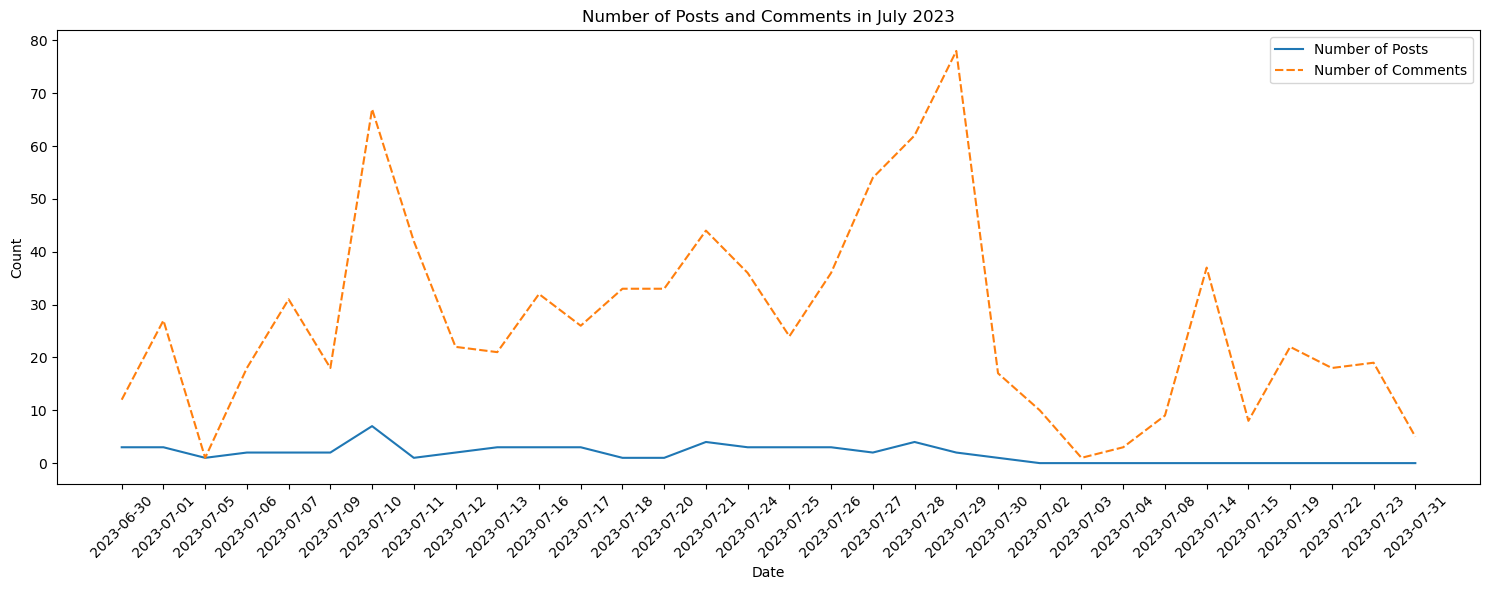

In [6]:
#Time Series Plot for Posts and Comments
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
sns.lineplot(data=df)
plt.title('Number of Posts and Comments in July 2023')
plt.ylabel('Count')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

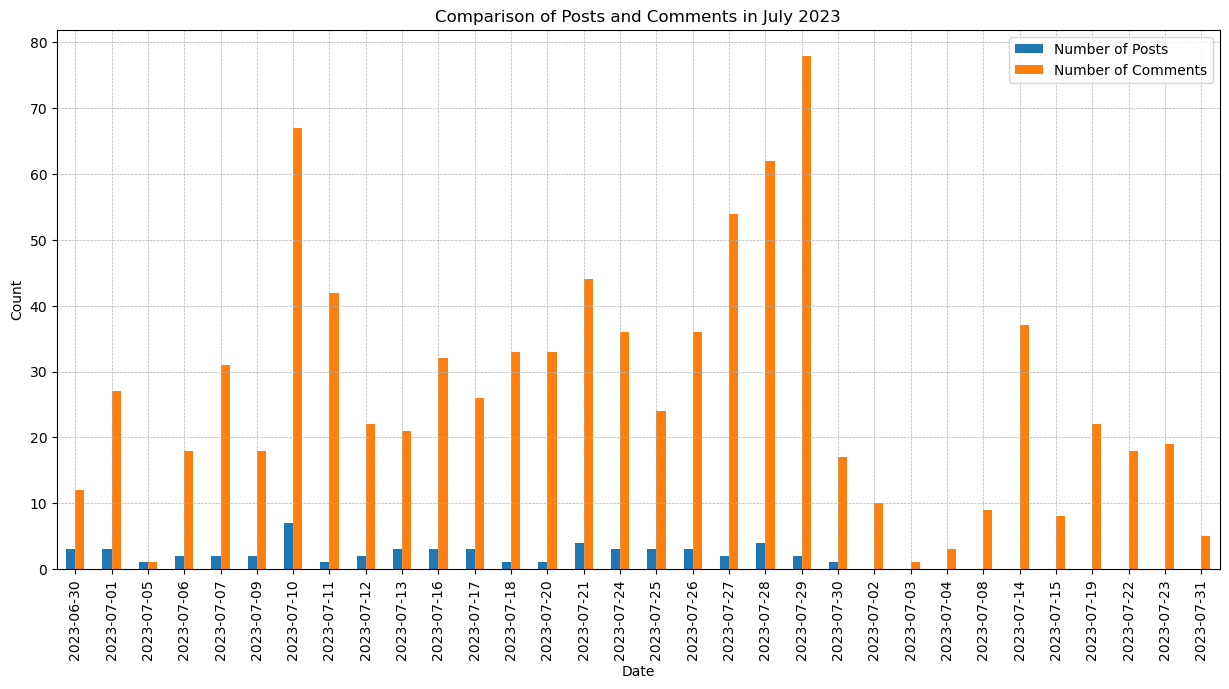

In [7]:
#side-by-side bar plot to compare the number of posts and comments for each day
df.plot(kind='bar', figsize=(15,7))
plt.title('Comparison of Posts and Comments in July 2023')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [8]:
#to find out the day with highest number of posts
max_posts_date = df['Number of Posts'].idxmax()
print(f"The day with the highest number of posts was: {max_posts_date}")

The day with the highest number of posts was: 2023-07-10


In [9]:
#to find out the day with highest number of comments
max_comments_date = df['Number of Comments'].idxmax()
print(f"The day with the highest number of comments was: {max_comments_date}")


The day with the highest number of comments was: 2023-07-29


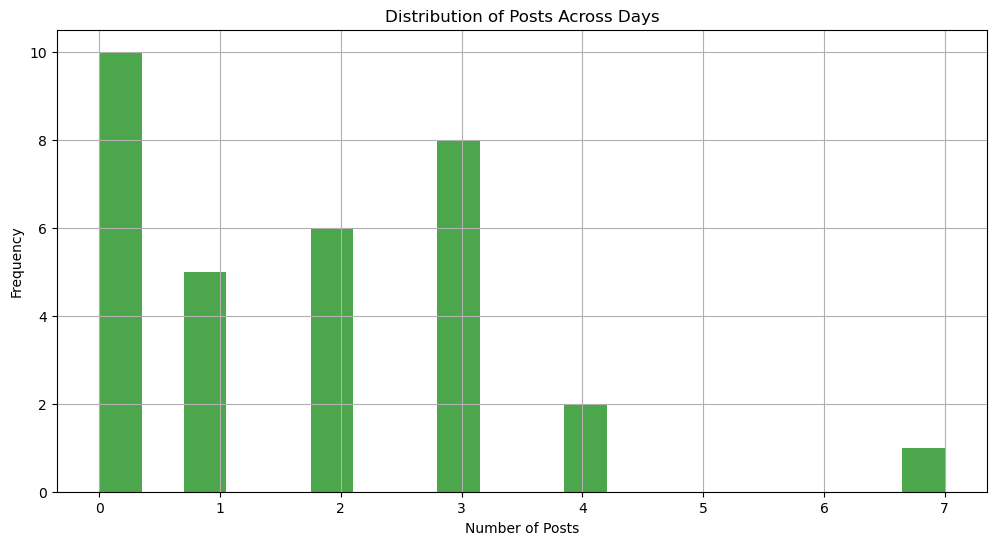

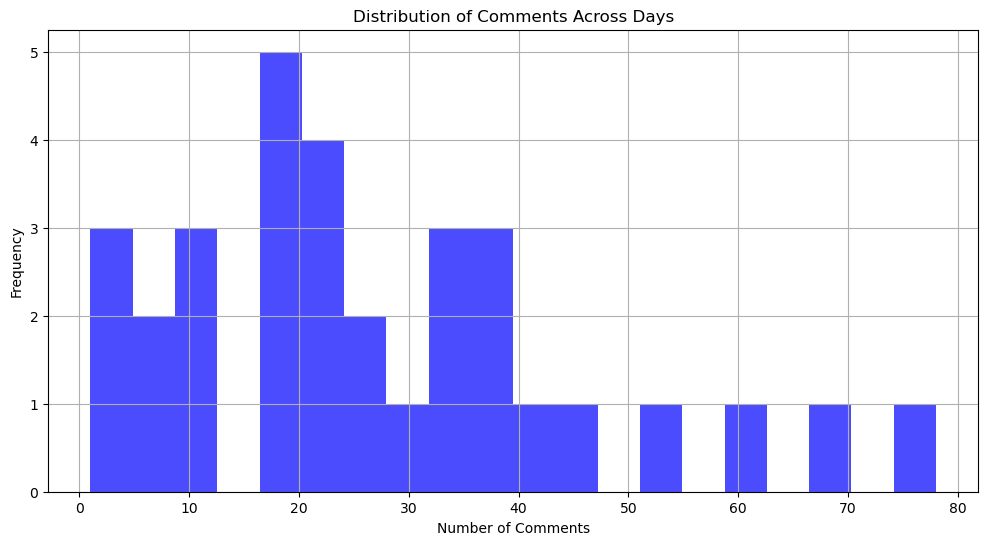

In [10]:
#histogram for the distribution of comments and posts
import matplotlib.pyplot as plt

# Histogram for number of posts
plt.figure(figsize=(12, 6))
plt.hist(df['Number of Posts'], bins=20, color='green', alpha=0.7)
plt.title('Distribution of Posts Across Days')
plt.xlabel('Number of Posts')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram for number of comments
plt.figure(figsize=(12, 6))
plt.hist(df['Number of Comments'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Comments Across Days')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

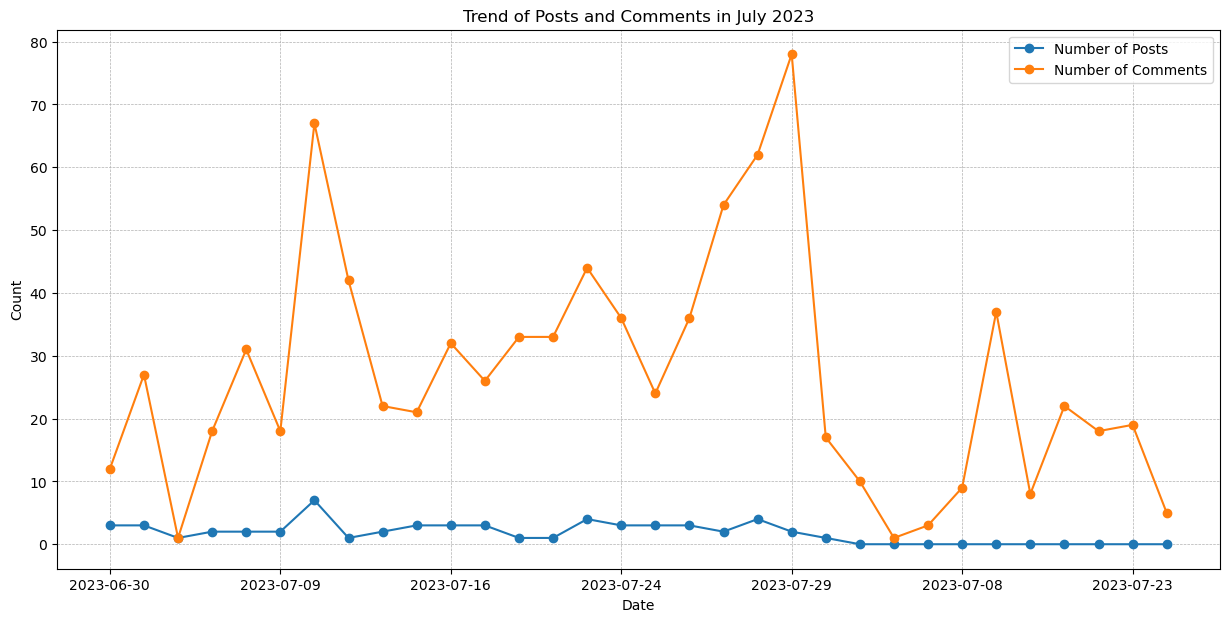

In [11]:
#simple line plot to see the trends
df.plot(figsize=(15,7), marker='o')
plt.title('Trend of Posts and Comments in July 2023')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [12]:
#removing duplicated words
posts_data = pd.DataFrame(posts_data).drop_duplicates()
comments_data = pd.DataFrame(comments_data).drop_duplicates()

In [13]:
#conversion to lowercase
posts_data['post_title'] = posts_data['post_title'].str.lower()
comments_data['comment_body'] = comments_data['comment_body'].str.lower()

In [14]:
#removing non-english entries
from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return None

posts_data['language'] = posts_data['post_title'].apply(detect_language)
comments_data['language'] = comments_data['comment_body'].apply(detect_language)

posts_data = posts_data[posts_data['language'] == 'en']
comments_data = comments_data[comments_data['language'] == 'en']


In [15]:
#tokenization
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

posts_data['tokens'] = posts_data['post_title'].apply(word_tokenize)
comments_data['tokens'] = comments_data['comment_body'].apply(word_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/swetakarmacharya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
#removing stop words
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

posts_data['tokens'] = posts_data['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
comments_data['tokens'] = comments_data['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swetakarmacharya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
#lemmatization
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

posts_data['tokens'] = posts_data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
comments_data['tokens'] = comments_data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/swetakarmacharya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
#sentiment analysis
from textblob import TextBlob

posts_data['sentiment'] = posts_data['post_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
comments_data['sentiment'] = comments_data['comment_body'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [19]:
#clssifying sentiments and checking counts
def classify_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

posts_data['sentiment_class'] = posts_data['sentiment'].apply(classify_sentiment)
comments_data['sentiment_class'] = comments_data['sentiment'].apply(classify_sentiment)

print("Posts Sentiments:")
print(posts_data['sentiment_class'].value_counts())

print("\nComments Sentiments:")
print(comments_data['sentiment_class'].value_counts())


Posts Sentiments:
sentiment_class
Neutral     29
Negative    13
Positive    12
Name: count, dtype: int64

Comments Sentiments:
sentiment_class
Positive    468
Neutral     192
Negative    125
Name: count, dtype: int64


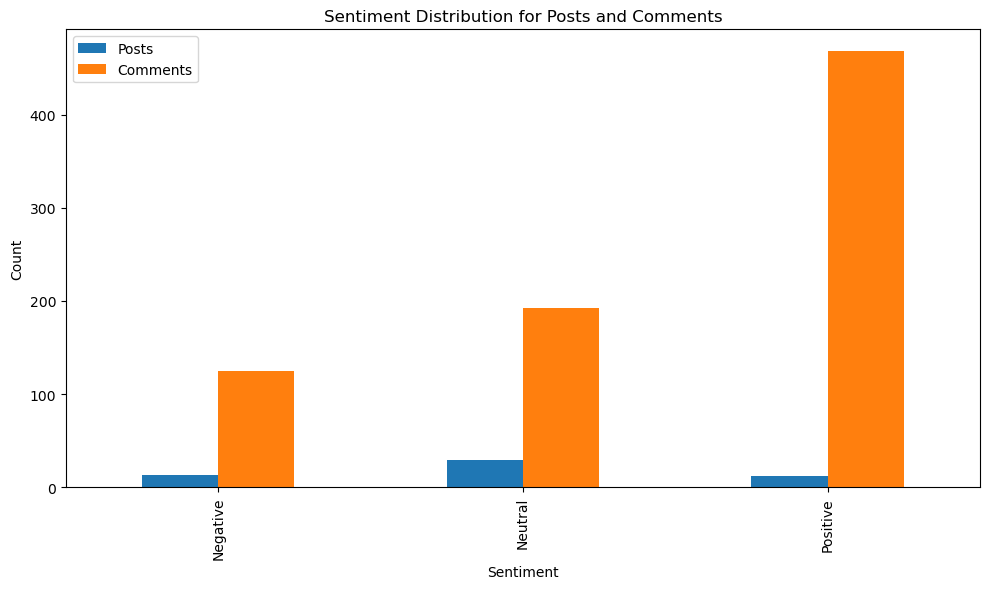

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

posts_sentiment_counts = posts_data['sentiment_class'].value_counts()
comments_sentiment_counts = comments_data['sentiment_class'].value_counts()

# Creating a new dataframe with side-by-side values for posts and comments
df = pd.DataFrame({'Posts': posts_sentiment_counts, 'Comments': comments_sentiment_counts})

df.plot(kind='bar', figsize=(10, 6), title="Sentiment Distribution for Posts and Comments")
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()


In [21]:
#checking counts of SpaceX and its competitors
competitors = ['blue origin', 'boeing', 'roscosmos']
mentions = {competitor: 0 for competitor in competitors}
mentions['spacex'] = 0

for _, row in posts_data.iterrows():
    for competitor in competitors:
        if competitor in row['post_title'].lower():
            mentions[competitor] += 1
    if 'spacex' in row['post_title'].lower():
        mentions['spacex'] += 1

for _, row in comments_data.iterrows():
    for competitor in competitors:
        if competitor in row['comment_body'].lower():
            mentions[competitor] += 1
    if 'spacex' in row['comment_body'].lower():
        mentions['spacex'] += 1

print(mentions)


{'blue origin': 11, 'boeing': 13, 'roscosmos': 0, 'spacex': 240}


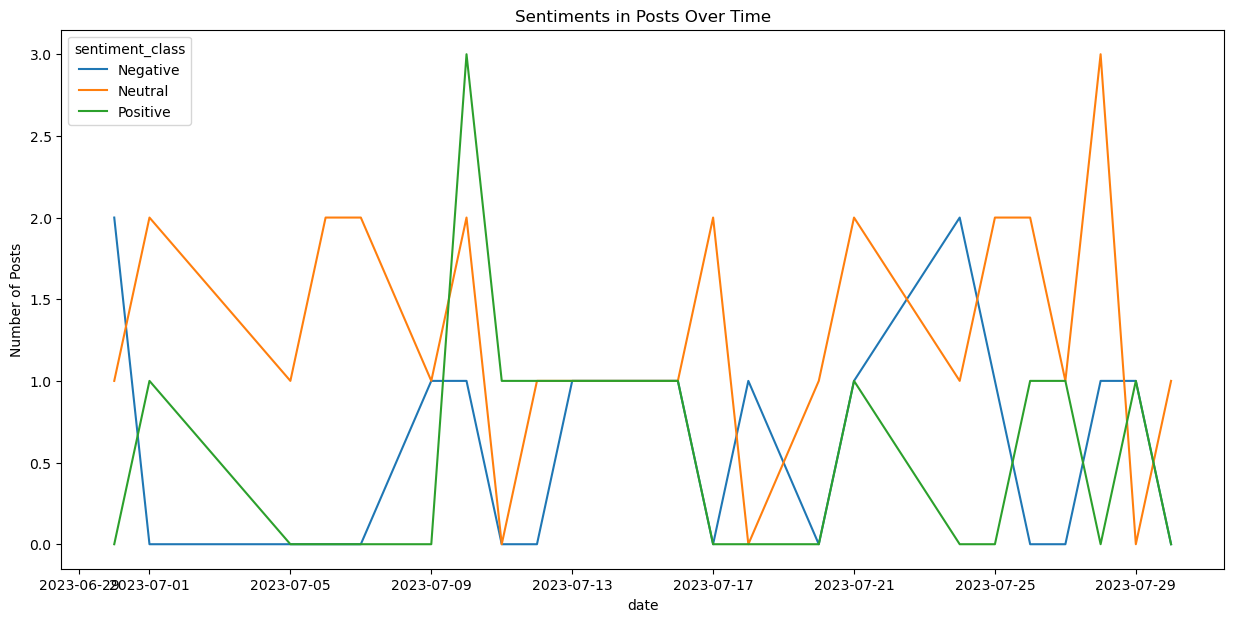

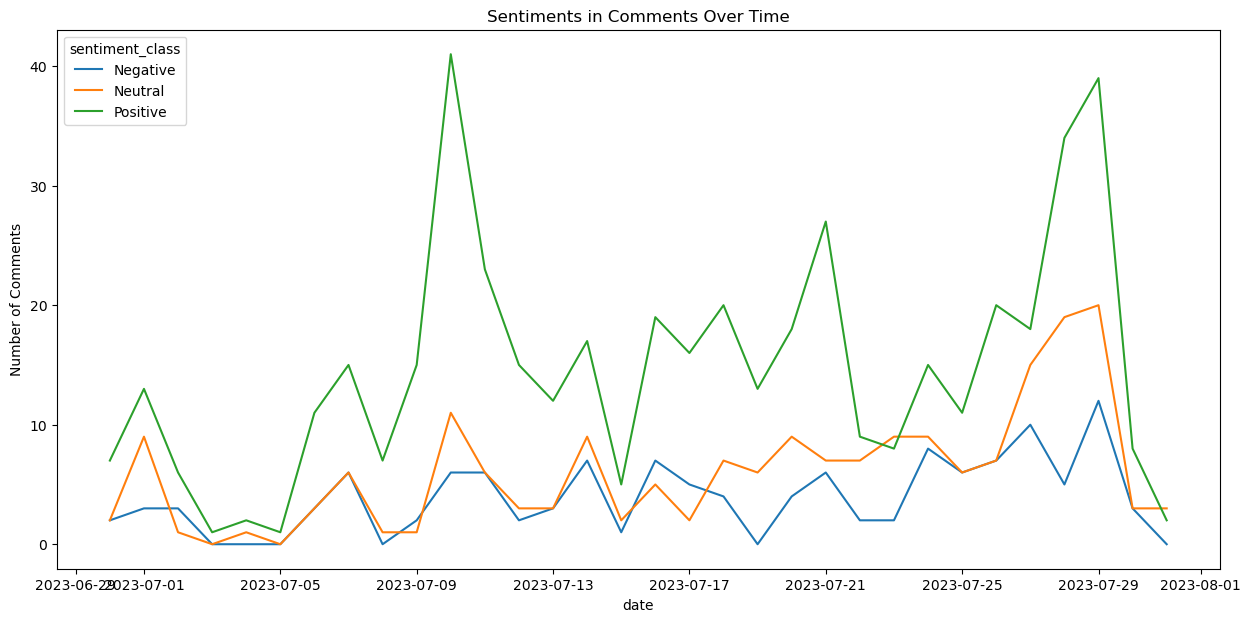

In [22]:
#plotting the distribution of sentiments over time
import matplotlib.pyplot as plt

posts_data['date'] = pd.to_datetime(posts_data['timestamp'], unit='s').dt.date
comments_data['date'] = pd.to_datetime(comments_data['timestamp'], unit='s').dt.date

grouped_posts = posts_data.groupby('date')['sentiment_class'].value_counts().unstack().fillna(0)
grouped_comments = comments_data.groupby('date')['sentiment_class'].value_counts().unstack().fillna(0)

grouped_posts.plot(kind='line', figsize=(15, 7), title="Sentiments in Posts Over Time")
plt.ylabel('Number of Posts')
plt.show()

grouped_comments.plot(kind='line', figsize=(15, 7), title="Sentiments in Comments Over Time")
plt.ylabel('Number of Comments')
plt.show()


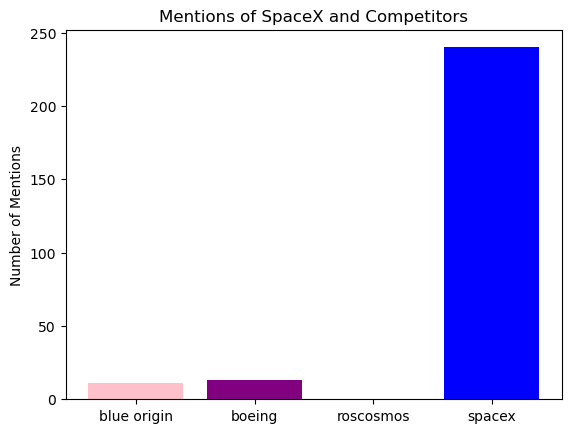

In [23]:
#visualization of the mentions of SpaceX and its competitors
plt.bar(mentions.keys(), mentions.values(), color=['pink', 'purple', 'yellow', 'blue'])
plt.title('Mentions of SpaceX and Competitors')
plt.ylabel('Number of Mentions')
plt.show()


In [24]:
#topic modelling
import gensim
from gensim import corpora
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

#Tokenize the titles
posts_data['tokens'] = posts_data['post_title'].apply(lambda x: [word for word in word_tokenize(x.lower()) 
                                                                 if word.isalpha() and word not in stop_words])

#Create Dictionary
dictionary = corpora.Dictionary(posts_data['tokens'])

#Create Corpus: Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in posts_data['tokens']]


In [25]:
#Use LDA model from gensim
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=10, workers=2)

#Display the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.023*"spacex" + 0.016*"starship" + 0.016*"nasa" + 0.016*"booster" + 0.016*"launch" + 0.016*"space" + 0.016*"commercial" + 0.016*"revenue" + 0.016*"flight" + 0.009*"heavy"
Topic: 1 
Words: 0.046*"thread" + 0.042*"launch" + 0.042*"discussion" + 0.037*"official" + 0.037*"updates" + 0.032*"starlink" + 0.016*"first" + 0.016*"twitter" + 0.012*"falcon" + 0.011*"spacex"
Topic: 2 
Words: 0.037*"launch" + 0.032*"spacex" + 0.023*"twitter" + 0.019*"falcon" + 0.014*"nasa" + 0.014*"lsp" + 0.014*"heavy" + 0.010*"brought" + 0.010*"control" + 0.010*"new"
Topic: 3 
Words: 0.033*"spacex" + 0.021*"launch" + 0.020*"starlink" + 0.020*"falcon" + 0.014*"satellites" + 0.014*"seen" + 0.008*"earth" + 0.008*"crew" + 0.008*"built" + 0.008*"starting"
Topic: 4 
Words: 0.056*"spacex" + 0.028*"twitter" + 0.024*"test" + 0.024*"heavy" + 0.019*"launch" + 0.015*"flame" + 0.015*"year" + 0.013*"launches" + 0.011*"falcon" + 0.010*"starship"


In [26]:
import pyLDAvis.gensim_models

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.081486  0.104920       1        1  26.495271
4      0.036081 -0.094686       2        1  25.276567
1     -0.150012  0.027917       3        1  21.170975
3      0.004437 -0.005231       4        1  15.196538
0      0.028008 -0.032920       5        1  11.860648, topic_info=           Term      Freq     Total Category  logprob  loglift
73   discussion  5.000000  5.000000  Default  30.0000  30.0000
75       thread  6.000000  6.000000  Default  29.0000  29.0000
76      updates  4.000000  4.000000  Default  28.0000  28.0000
74     official  4.000000  4.000000  Default  27.0000  27.0000
56     starlink  7.000000  7.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
35        heavy  0.594953  6.447953   Topic5  -4.7365  -0.2511
151     billion  0.594739  1.760293   Topic5  -4.7368   1.0468
110         pad  0.594616  3.042219   Topic5  -4.7370   0.4995
29      testing  0.594498  2.461985   Topic5  -4.7372   0.7109
79         crew  0.594386  1.651373   Topic5  -4.7374   1.1101

[239 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
77        4  0.865027      access
60        2  0.790439  activation
127       1  0.778446      aerial
105       2  0.568004       ahead
105       5  0.568004       ahead
...     ...       ...         ...
228       5  0.910849       would
48        1  0.513559           x
48        2  0.513559           x
59        2  0.648163        year
59        5  0.324081        year

[244 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])

/Users/swetakarmacharya/anaconda3/envs/Assignment1/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


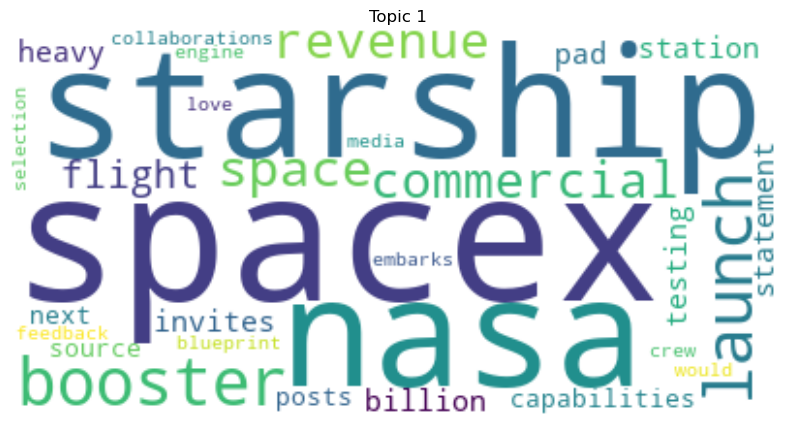

/Users/swetakarmacharya/anaconda3/envs/Assignment1/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


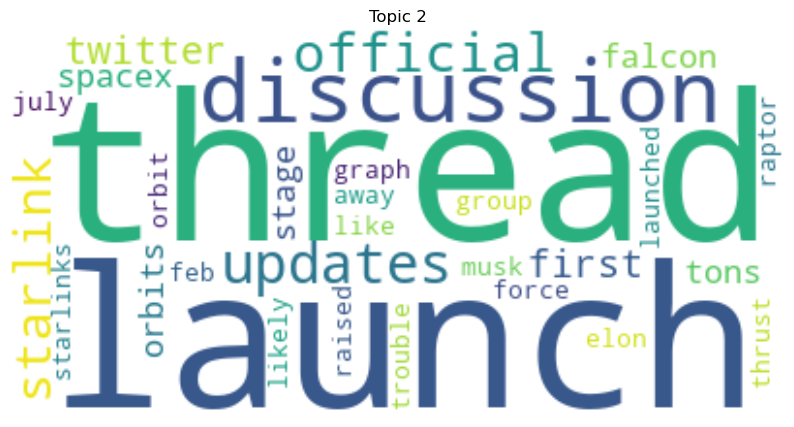

/Users/swetakarmacharya/anaconda3/envs/Assignment1/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


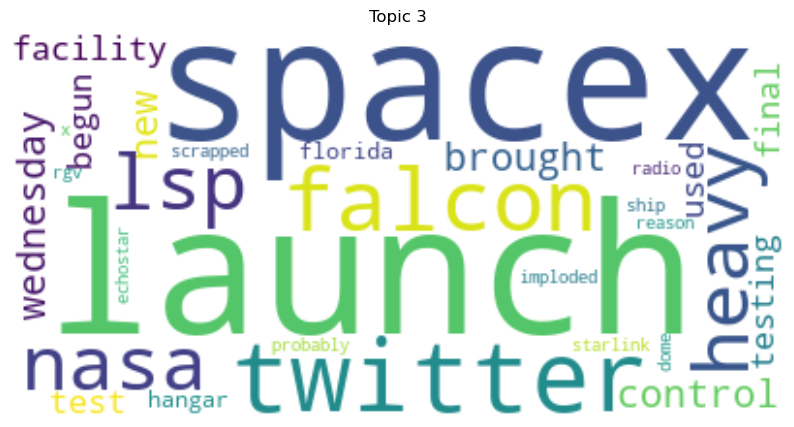

/Users/swetakarmacharya/anaconda3/envs/Assignment1/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


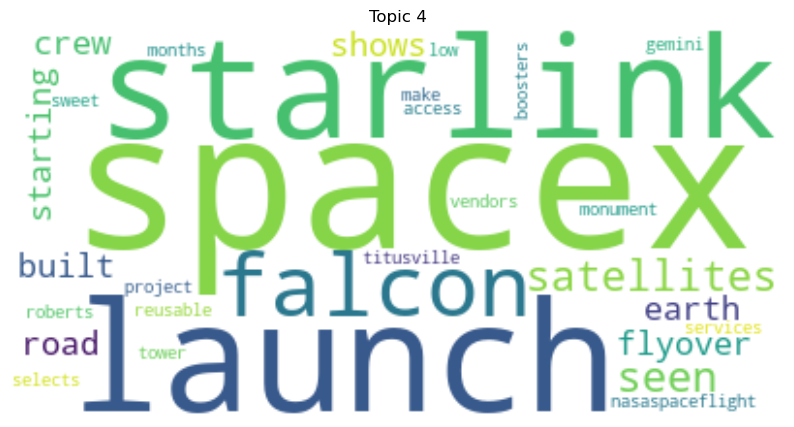

/Users/swetakarmacharya/anaconda3/envs/Assignment1/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


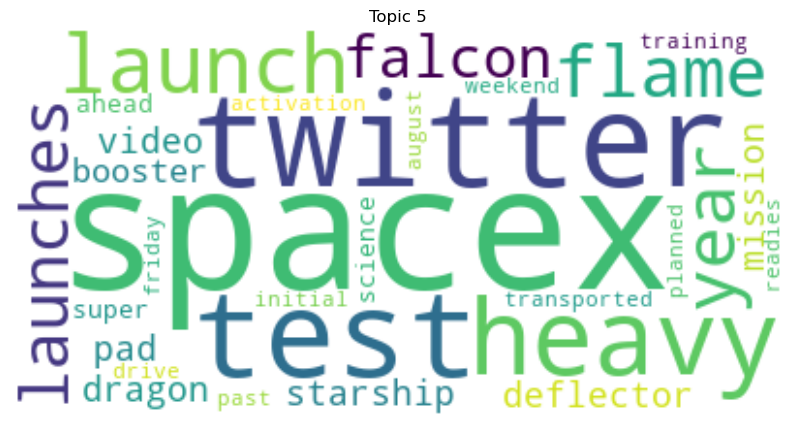

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#extracting topics into a format suitable for word clouds
def format_topics_for_wordcloud(lda_model, num_topics):
    topic_words = []

    for i in range(num_topics):
        topic_terms = lda_model.show_topic(i, topn=30)
        topic_dict = {word: probability for word, probability in topic_terms}
        topic_words.append(topic_dict)
    
    return topic_words

#getting topics from the LDA model
topics_for_wordcloud = format_topics_for_wordcloud(lda_model, 5)

#creating word clouds
for idx, topic in enumerate(topics_for_wordcloud):
    wc = WordCloud(background_color='white', max_words=50)
    wordcloud = wc.generate_from_frequencies(topic)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {idx + 1}")
    plt.axis('off')
    plt.show()


In [32]:
from collections import defaultdict

# Assigning each document to a topic
def get_dominant_topic(document, lda_model):
    topic_probs = lda_model[document]
    dominant_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0][0]
    return dominant_topic + 1  # Adjust the topic number to start from 1

documents = corpus  # Assuming 'corpus' is a list of documents
document_topics = [get_dominant_topic(doc, lda_model) for doc in documents]

document_sentiments = posts_data['sentiment'].tolist()

# Aggregating sentiments for each topic
topic_sentiments = defaultdict(list)

for topic, sentiment in zip(document_topics, document_sentiments):
    topic_sentiments[topic].append(sentiment)

# Calculating average sentiment for each topic
avg_topic_sentiments = {topic: sum(sentiments)/len(sentiments) for topic, sentiments in topic_sentiments.items()}

print(avg_topic_sentiments)


{3: -0.06767045454545455, 4: 0.03123456790123457, 5: -0.09327376327376327, 2: 0.04625850340136054, 1: 0.05416666666666667}
